# We will try tracking the hands with just 6 landmarks, which will be a 6 x 3 x 2 = 36 length vector for each time step. 

In [13]:
import cv2, os 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [20]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [3]:
"""read in all of the frames"""

SECONDS_TO_DETECT = 2 # in seconds

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/shorter_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/shorter_control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

armflapping_videos:  19%|█▊        | 20/108 [00:00<00:02, 32.48it/s]

failed on .DS_Store


control_videos:  19%|█▉        | 12/62 [00:01<00:06,  7.99it/s]

failed on .DS_Store


control_videos: 100%|██████████| 62/62 [00:06<00:00,  9.80it/s]


(97, 50)

In [5]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

100%|██████████| 50/50 [01:44<00:00,  2.10s/it]


In [6]:
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

50it [00:00, 21340.71it/s]
50it [00:00, 12007.74it/s]

(50, 90, 36) (50, 90, 36)


In [7]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 

X, y = generate_data(padded_armflapping_locations, padded_control_locations)

In [8]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [35]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] 
        Y_locations = X[:, 42:84] 
        Z_locations = X[:, 84:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:, 42:84] + mask * tf.ones_like(X[:, 42:84]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:, 42:84] - mask * tf.ones_like(X[:, 42:84]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:, :42] + mask * tf.ones_like(X[:, :42]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:, :42] - mask * tf.ones_like(X[:, :42]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:, 84:] + mask * tf.ones_like(X[:, 84:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:, 84:] - mask * tf.ones_like(X[:, 84:]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  
        

In [29]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [18]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")
        
    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve")
    plt.show() 

In [19]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")
    plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 

In [50]:
import random 
def shuffle(X, y, seed = None):
    if not seed:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y
X, y = shuffle(X, y)

using seed 77


In [45]:
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences=False), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation="sigmoid") 
    ]) 

    model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model 

Epoch 1/125
3/3 [==============================] - 1s 227ms/step - loss: 0.6979 - accuracy: 0.4375 - precision_36: 0.2667 - recall_36: 0.1053 - val_loss: 0.7376 - val_accuracy: 0.1500 - val_precision_36: 0.1429 - val_recall_36: 0.0833
Epoch 2/125
3/3 [==============================] - 1s 277ms/step - loss: 0.6938 - accuracy: 0.3875 - precision_36: 0.3103 - recall_36: 0.2368 - val_loss: 0.7238 - val_accuracy: 0.2000 - val_precision_36: 0.2500 - val_recall_36: 0.1667
Epoch 3/125
3/3 [==============================] - 0s 157ms/step - loss: 0.6855 - accuracy: 0.4250 - precision_36: 0.3947 - recall_36: 0.3947 - val_loss: 0.7137 - val_accuracy: 0.2500 - val_precision_36: 0.3333 - val_recall_36: 0.2500
Epoch 4/125
3/3 [==============================] - 0s 145ms/step - loss: 0.6803 - accuracy: 0.4375 - precision_36: 0.4186 - recall_36: 0.4737 - val_loss: 0.7061 - val_accuracy: 0.3000 - val_precision_36: 0.4000 - val_recall_36: 0.3333
Epoch 5/125
3/3 [==============================] - 0s 150ms/

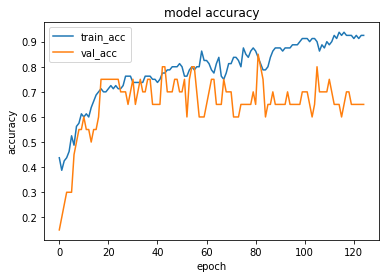

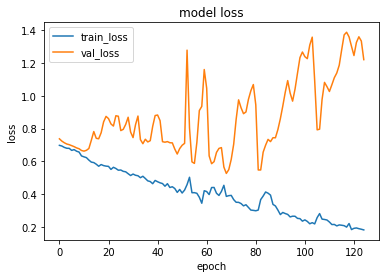

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.54958475]]


1it [00:00, 14027.77it/s]


prediction for video armflapping_3.mov is [[0.6829623]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.6409974]]


1it [00:00, 15827.56it/s]


prediction for video control_1.mov is [[0.717973]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.02298373]]


1it [00:00, 12787.51it/s]


prediction for video control_3.mov is [[0.7591021]]
Epoch 1/125
3/3 [==============================] - 1s 229ms/step - loss: 0.6991 - accuracy: 0.4375 - precision_37: 0.4681 - recall_37: 0.5238 - val_loss: 0.6936 - val_accuracy: 0.4500 - val_precision_37: 0.4211 - val_recall_37: 1.0000
Epoch 2/125
3/3 [==============================] - 0s 150ms/step - loss: 0.6838 - accuracy: 0.5250 - precision_37: 0.5312 - recall_37: 0.8095 - val_loss: 0.6893 - val_accuracy: 0.4500 - val_precision_37: 0.4211 - val_recall_37: 1.0000
Epoch 3/125
3/3 [==============================] - 0s 154ms/step - loss: 0.6820 - accuracy: 0.5625 - precision_37: 0.5479 - recall_37: 0.9524 - val_loss: 0.6849 - val_accuracy: 0.4500 - val_precision_37: 0.4211 - val_recall_37: 1.0000
Epoch 4/125
3/3 [==============================] - 0s 160ms/step - loss: 0.6780 - accuracy: 0.6125 - precision_37: 0.5775 - recall_37: 0.9762 - val_loss: 0.6808 - val_accuracy: 0.4500 - val_precision_37: 0.4211 - val_recall_37: 1.0000
Epoch 5/

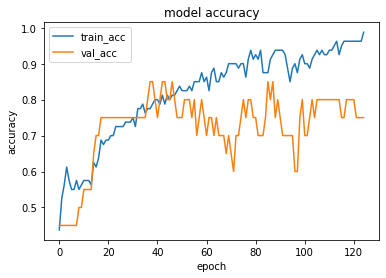

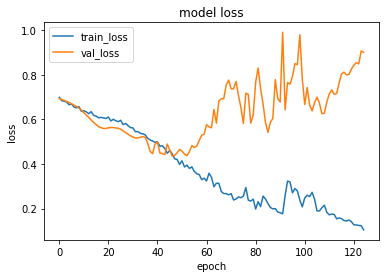

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.80648327]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_3.mov is [[0.9853559]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.9789244]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.9320444]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.19524601]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.6793569]]
Epoch 1/125
3/3 [==============================] - 1s 234ms/step - loss: 0.6980 - accuracy: 0.5500 - precision_38: 0.5455 - recall_38: 0.7317 - val_loss: 0.7013 - val_accuracy: 0.6000 - val_precision_38: 0.5294 - val_recall_38: 1.0000
Epoch 2/125
3/3 [==============================] - 0s 161ms/step - loss: 0.6842 - accuracy: 0.5875 - precision_38: 0.5645 - recall_38: 0.8537 - val_loss: 0.6992 - val_accuracy: 0.4500 - val_precision_38: 0.4286 - val_recall_38: 0.6667
Epoch 3/125
3/3 [==============================] - 0s 152ms/step - loss: 0.6847 - accuracy: 0.6375 - precision_38: 0.6111 - recall_38: 0.8049 - val_loss: 0.6990 - val_accuracy: 0.4500 - val_precision_38: 0.4286 - val_recall_38: 0.6667
Epoch 4/125
3/3 [==============================] - 0s 152ms/step - loss: 0.6701 - accuracy: 0.7375 - precision_38: 0.6852 - recall_38: 0.9024 - val_loss: 0.7006 - val_accuracy: 0.5000 - val_precision_38: 0.4615 - val_recall_38: 0.6667
Epoch 5/

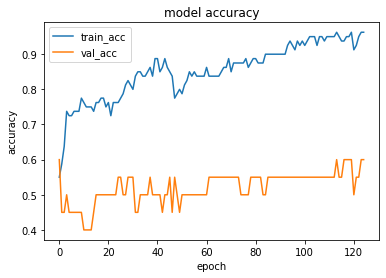

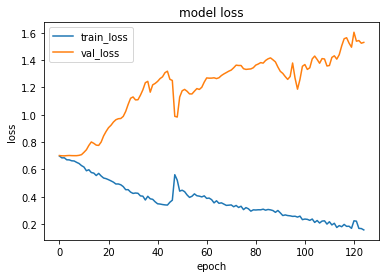

1it [00:00, 19691.57it/s]


prediction for video armflapping_1.mov is [[0.7961614]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.97541773]]


1it [00:00, 11491.24it/s]


prediction for video armflapping_2.mov is [[0.83339506]]


1it [00:00, 15827.56it/s]


prediction for video control_1.mov is [[0.08219138]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.07616153]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.23751116]]
Epoch 1/125
3/3 [==============================] - 1s 215ms/step - loss: 0.7026 - accuracy: 0.4000 - precision_39: 0.4000 - recall_39: 0.4615 - val_loss: 0.6975 - val_accuracy: 0.5000 - val_precision_39: 0.5263 - val_recall_39: 0.9091
Epoch 2/125
3/3 [==============================] - 0s 148ms/step - loss: 0.6915 - accuracy: 0.5000 - precision_39: 0.4921 - recall_39: 0.7949 - val_loss: 0.6942 - val_accuracy: 0.5500 - val_precision_39: 0.5556 - val_recall_39: 0.9091
Epoch 3/125
3/3 [==============================] - 0s 130ms/step - loss: 0.6794 - accuracy: 0.6375 - precision_39: 0.5893 - recall_39: 0.8462 - val_loss: 0.6911 - val_accuracy: 0.6000 - val_precision_39: 0.6000 - val_recall_39: 0.8182
Epoch 4/125
3/3 [==============================] - 0s 132ms/step - loss: 0.6869 - accuracy: 0.5875 - precision_39: 0.5577 - recall_39: 0.7436 - val_loss: 0.6883 - val_accuracy: 0.6500 - val_precision_39: 0.6429 - val_recall_39: 0.8182
Epoch 5

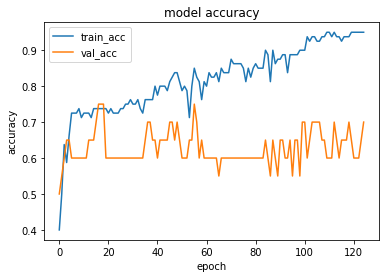

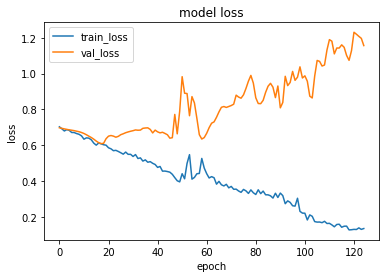

1it [00:00, 17623.13it/s]


prediction for video armflapping_1.mov is [[0.86459434]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_3.mov is [[0.95513713]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_2.mov is [[0.9454931]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.6400686]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.2228691]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.04977429]]
Epoch 1/125
3/3 [==============================] - 1s 338ms/step - loss: 0.6971 - accuracy: 0.4375 - precision_40: 0.4242 - recall_40: 0.3500 - val_loss: 0.7051 - val_accuracy: 0.2500 - val_precision_40: 0.2222 - val_recall_40: 0.2000
Epoch 2/125
3/3 [==============================] - 0s 149ms/step - loss: 0.6944 - accuracy: 0.4625 - precision_40: 0.4681 - recall_40: 0.5500 - val_loss: 0.7006 - val_accuracy: 0.2000 - val_precision_40: 0.2500 - val_recall_40: 0.3000
Epoch 3/125
3/3 [==============================] - 0s 150ms/step - loss: 0.6850 - accuracy: 0.4875 - precision_40: 0.4902 - recall_40: 0.6250 - val_loss: 0.6950 - val_accuracy: 0.2000 - val_precision_40: 0.2500 - val_recall_40: 0.3000
Epoch 4/125
3/3 [==============================] - 0s 152ms/step - loss: 0.6815 - accuracy: 0.4875 - precision_40: 0.4912 - recall_40: 0.7000 - val_loss: 0.6884 - val_accuracy: 0.4500 - val_precision_40: 0.4706 - val_recall_40: 0.8000
Epoch 5

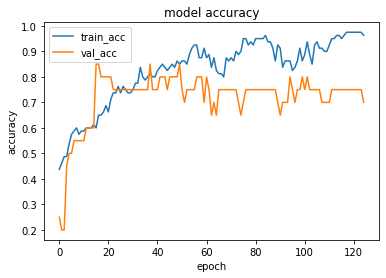

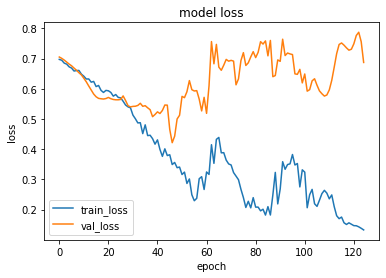

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.09570497]]


1it [00:00, 20763.88it/s]


prediction for video armflapping_3.mov is [[0.93608665]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.11390108]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.08853033]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.08780685]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.08533558]]


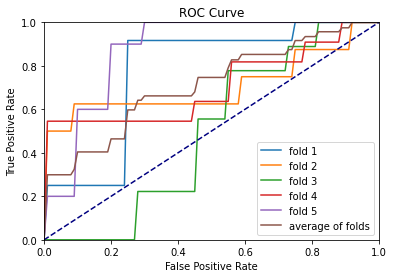

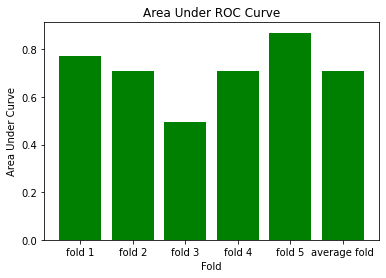

In [52]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 125, callbacks = [checkpoint])